1. Сколько у нас пользователей, которые совершили покупку только один раз? 


2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 


3. По каждому товару определить, в какой день недели товар чаще всего покупается. 


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. 


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким 
   retention на 3й месяц. 
   

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### Импортируем необходимые библиотеки

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю

unavailable —  недоступен

canceled —  отменён

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser
import plotly.express as px

### данные из таблицы olist_customers_datase

**olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей**
 
- customer_id — позаказный идентификатор пользователя

- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

### данные из таблицы olist_orders

**olist_orders_dataset.csv —  таблица заказов**

- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

### данные из таблицы olist_order_items

**olist_order_items_dataset.csv —  товарные позиции, входящие в заказы**

- order_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара

In [5]:
users = pd.read_csv('~/first_project/olist_customers_dataset.csv')
items = pd.read_csv('~/first_project/olist_order_items_dataset.csv')
orders  = pd.read_csv('~/first_project/olist_orders_dataset.csv')

In [6]:
users.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [7]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [8]:
#Остановимся подробнее на статусах заказов

In [9]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [10]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [11]:

#1. Отфильтровать те заказы, статус которых соответствует покупке (за покупку принимаем:)
#2. Для каждого пользователя расчитать количество покупок
#3. Отфильтровать пользователей с 1 покупкой 
#4. Посчитать количесвто уникальных customer_id



task_1 = (
    orders.query('order_status != " created"')\
    .merge(users, on = 'customer_id')\
    .groupby('customer_unique_id', as_index=False)\
    .order_id.nunique()\
    .query('order_id == 1')\
    .customer_unique_id.nunique()
)

In [12]:
task_1

93099

In [13]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


### По итогу у нас   **93099**, которые совершили покупку всего один раз

### 2.  Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

In [ ]:
# 1 вариант

In [14]:
# 1.Отфильтровать те заказы , статус которых соответсвует негативному событию (что считаем не доставленным заказом)
# 2. Расчитать месяц на основе дат ( самый простой способо - отрезать год и месяц)
# 3. Для каждого месяца и каждого негативгого статуса  расчитать уникальное количество заказов
# 4. Для каждого статуса расчитать среднее количесвто заказов по месяцам

task_2 = (
    orders[orders.order_status.isin(['unavailable', 'canceled'])]
    .assign(month = lambda row: row.order_purchase_timestamp.str[:7])  # добавляем колонку month
    .groupby(['month', 'order_status'], as_index=False)
    .order_id.nunique()
    .groupby('order_status', as_index=False)
    .order_id.mean()
)

In [15]:
task_2

,order_status,order_id
0,canceled,26.041667
1,unavailable,29.000000


In [ ]:
# 2 вариант

In [128]:
# Рассмотрим фрейм "customers_and_orders". Подсчитаем количество заказов, у которых статус != delivered или 
# нет времени доставки, сгруппируем по статусу и посчитаем количество таких заказов

In [130]:
not_delivered = users_and_orders.query('order_status != "delivered" or order_delivered_customer_date.isna()').\
groupby('order_status', as_index = False).\
agg(not_delivered_count = ('order_id', 'count'))

In [131]:
not_delivered.head()

,order_status,not_delivered_count
0,approved,2
1,canceled,625
2,created,5
3,delivered,8
4,invoiced,314


In [ ]:
# Исключим из рассмотрения заказы со статусами: approved, created, invoiced, processing, shipped - так как это этапы поставки
# и нельзя считать, что товар не доставлен.
# Рассмотрим заказы со статусами canceled и unavailable.


In [ ]:
# Также видим, что в получившемся фрейме присутствуют заказы со статусом delivered.
# Это означает, с учетом сделанного выше запроса, что заказ вроде как имеет статус доставлен,
# но времени доставки нет - такие заказы тоже рассмотрим как отдельный случай.

In [133]:
not_delivered_final = users_and_orders.query('order_status == "canceled" \
or order_status == "unavailable" \
or order_status == "delivered" and order_delivered_customer_date.isna()')

In [134]:
not_delivered_final.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,other_buy
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaN,NaN,2018-04-09 00:00:00,2018-03
288,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,16011,aracatuba,SP,df8c077268f7f3baaac0892eb3143642,unavailable,2017-02-01 00:04:17,2017-02-01 00:30:55,NaN,NaN,2017-03-10 00:00:00,2017-02
373,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,28495,aperibe,RJ,c609f82bcf7a90292a5940205ebd7e93,unavailable,2018-05-13 16:45:55,2018-05-13 17:11:58,NaN,NaN,2018-06-05 00:00:00,2018-05


In [137]:
not_delivered_final.order_purchase_timestamp = pd.to_datetime(not_delivered_final.order_purchase_timestamp)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [138]:
# Так как нам необходим сделать разбивку по месяцам, добавим во фрейм выше столбец с месяцами

In [139]:
not_delivered_final['order_purchase_month'] = not_delivered_final.order_purchase_timestamp.dt.strftime('%Y-%m')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
not_delivered_final.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,other_buy,order_purchase_month
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaN,NaN,2018-04-09 00:00:00,2018-03,2018-03
288,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,16011,aracatuba,SP,df8c077268f7f3baaac0892eb3143642,unavailable,2017-02-01 00:04:17,2017-02-01 00:30:55,NaN,NaN,2017-03-10 00:00:00,2017-02,2017-02
373,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,28495,aperibe,RJ,c609f82bcf7a90292a5940205ebd7e93,unavailable,2018-05-13 16:45:55,2018-05-13 17:11:58,NaN,NaN,2018-06-05 00:00:00,2018-05,2018-05


In [ ]:
# посмотрим, как менялось с течением времени количество недоставок в зависимости от статуса заказа

In [142]:
not_delivered_final_1 = not_delivered_final.groupby(['order_status', 'order_purchase_month'], as_index = False).\
agg(not_delivered_per_month = ('order_id', 'count'))
not_delivered_final_1.head(3)

,order_status,order_purchase_month,not_delivered_per_month
0,canceled,2016-09,2
1,canceled,2016-10,24
2,canceled,2017-01,3


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


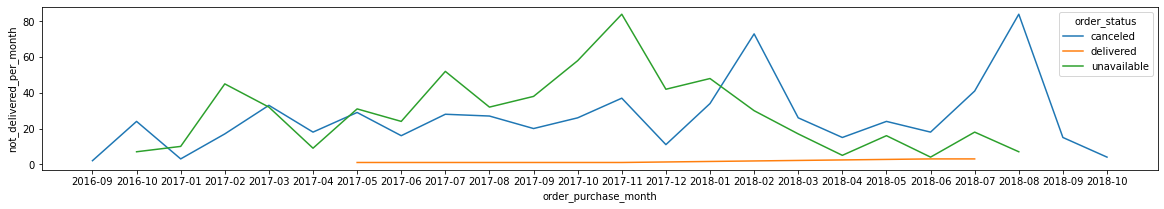

In [143]:
plt.figure(figsize=(20,3))
sns.lineplot(not_delivered_final_1.order_purchase_month,\
             not_delivered_final_1.not_delivered_per_month,\
             hue = not_delivered_final_1.order_status)

In [ ]:
# посмотрим на количество оформленных и впоследствие купленных заказов по дням в ноябре 2017.
# Для этого используем фрейм "customers_and_orders_without_NAN_and_unav". 
# добавим колонку с днем и посчитаем число покупок в день

In [146]:
users_and_orders.order_purchase_timestamp = pd.to_datetime(users_and_orders.order_purchase_timestamp)

In [147]:
users_and_orders['order_purchase_timestamp_day'] = users_and_orders.order_purchase_timestamp.dt.strftime('%Y-%m-%d')

In [148]:
users_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,other_buy,order_purchase_timestamp_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05,2017-05-16
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,2018-01,2018-01-12
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,2018-05,2018-05-19
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,2018-03,2018-03-13
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,2018-07,2018-07-29


In [150]:
orders_in_2017_11 = users_and_orders.groupby(['order_purchase_timestamp_day'], as_index = False).\
agg(orders_per_day = ('order_id', 'count')).\
query('order_purchase_timestamp_day < "2017-12-01" and order_purchase_timestamp_day >= "2017-11-01"')

In [151]:
orders_in_2017_11.head(3)

,order_purchase_timestamp_day,orders_per_day
315,2017-11-01,111
316,2017-11-02,124
317,2017-11-03,143


In [152]:
# построим график по полученному выше фрейму

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


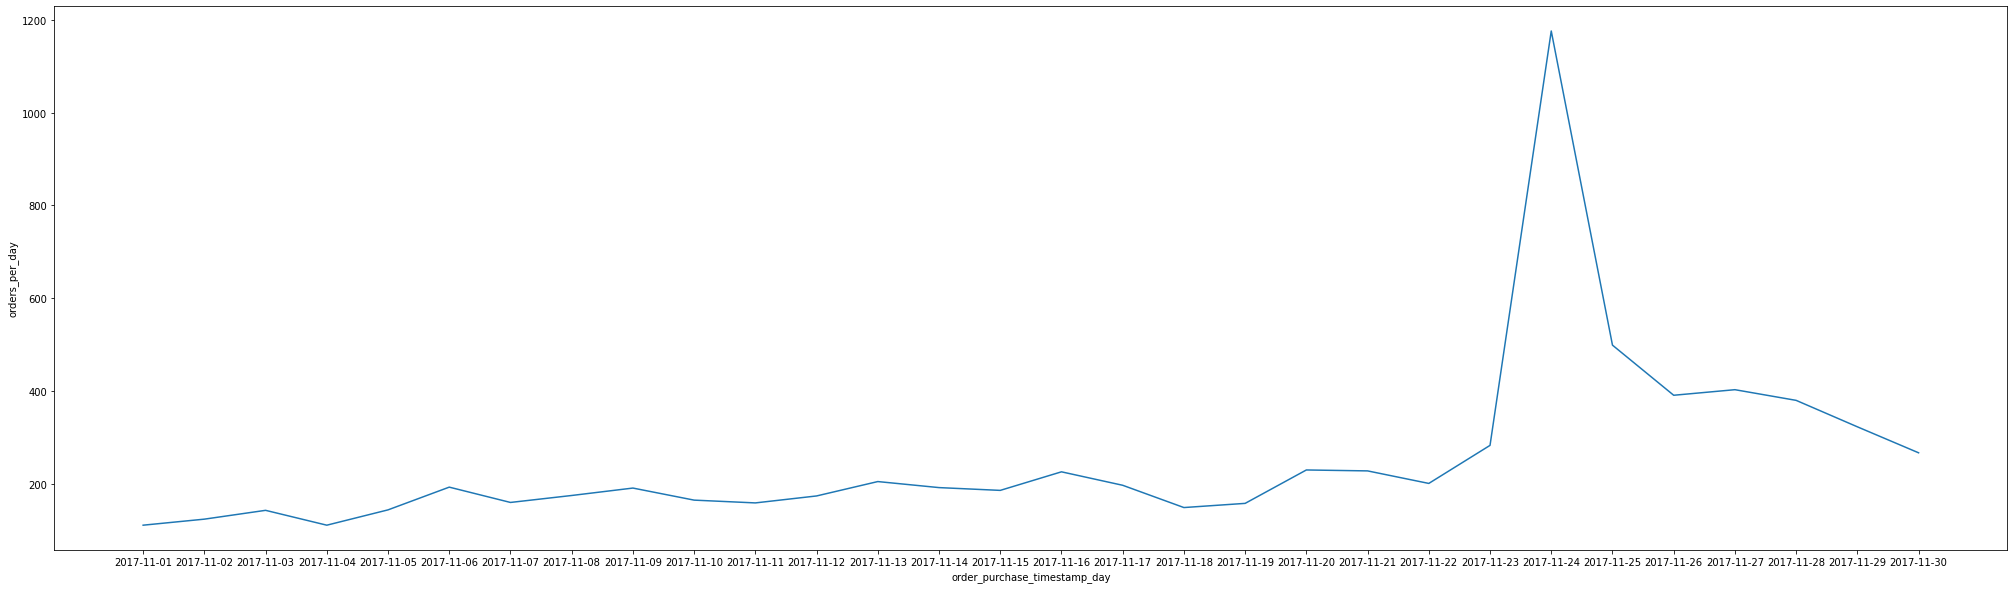

In [153]:
plt.figure(figsize=(35,10))
sns.lineplot(orders_in_2017_11.order_purchase_timestamp_day, orders_in_2017_11.orders_per_day)

In [ ]:
# Видим, что и в заказах, как и в недоставках есть явно выраженный пик по их количеству, 
# причем в определенный день - 24 ноября 2017. Посмотрев на просторах интернета, обнаружено,
# что в этот день проходила всеми известная "Черная пятница". Этим можно объяснить как большое количество оформленных заказов,
# так и большое число недоставленных товаров со статусом "unavailable".
# Огромное количество заказов и покупок в точечный момент времени -> системы перегружены -> происходят сбои -> 
# странный статус заказа, как баг программы.

In [ ]:
# сгруппируем получившийся фрейм "not_delivered_final" по статусу и месяцу, посчитаем число недоставок. 
# Впоследствие сгруппируемся снова по статусу заказа и посчитаем среднее число недоставок в месяц

In [154]:
not_delivered_final_per_month = not_delivered_final.groupby(['order_status', 'order_purchase_month'], as_index = False).\
agg({'order_id': 'count'}).\
groupby('order_status', as_index = False).\
agg(not_delivered_mean_per_month = ('order_id', 'mean')).\
round()

In [155]:
not_delivered_final_per_month.head(3)

,order_status,not_delivered_mean_per_month
0,canceled,26.0
1,delivered,2.0
2,unavailable,29.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


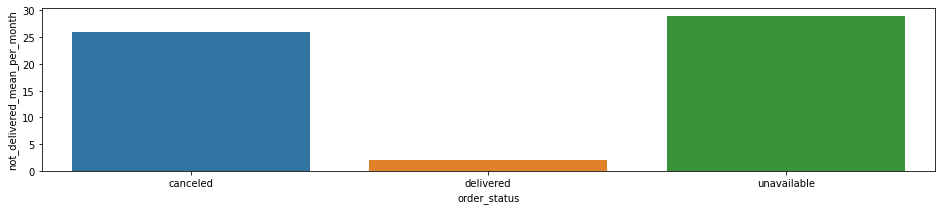

In [156]:
plt.figure(figsize=(16,3))
sns.barplot(not_delivered_final_per_month.order_status, not_delivered_final_per_month.not_delivered_mean_per_month)

Таким образом:  
    По причине отмены в среднем в месяц не доставляется 26 заказов;  
    По причине статуса "Unavailable" (багов?) - 29 заказов;  
    Заказов со статусом "Доставлен", при этом не имеющих времени доставки - в среднем 2 заказа в месяц
    (однако почему так происходит по имеющимся данным не ответить).

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [119]:
# 1 ввариант

In [16]:
# 1. К таблице items  приджойнить поле order_purchase_timestamp из  orders
# 2. Из поля order_purchase_timestamp получить номер дня недели (можно при помощи isocalenadar)
# 3. Для каждого товара выделить день, которму соответсвует наибольшее количесво продаж ( можно с помощью value_counts())



task_3 = (
    items.merge(orders[['order_id', 'order_purchase_timestamp']], on = 'order_id', how = 'left')    
)

task_3.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,2018-01-14 14:33:31


In [17]:
task_3['dayofweek'] = (
    task_3.order_purchase_timestamp
    .apply(lambda x: parser.parse(x).isocalendar()[2])  # год , номер дня недели , номер дня внутри недели
)
task_3.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,dayofweek
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,2017-09-13 08:59:02,3
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,2017-04-26 10:53:06,3
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,2018-01-14 14:33:31,7


In [18]:
task_3 = \
    task_3\
    .groupby('product_id', as_index = False)\
    .dayofweek.max()
task_3.head()

,product_id,dayofweek
0,00066f42aeeb9f3007548bb9d3f33c38,7
1,00088930e925c41fd95ebfe695fd2655,2
2,0009406fd7479715e4bef61dd91f2462,4
3,000b8f95fcb9e0096488278317764d19,5
4,000d9be29b5207b54e86aa1b1ac54872,2


In [22]:
#task_3 = (
#    task_3
#    .groupby('product_id', as_index = False)
  #  .dayofweek.value_counts())


In [ ]:
task_3

In [120]:
# 2 вариант

In [ ]:
# Так как речь в данном задании идет о покупаемых товаров,
# то оставим в силе наше определение покупки - заказы, имеющие факт оплаты и вне статуса "unavailable".

# Воспользуемся созданным ранее фреймом "users_and_orders" и объединим его с "items", 
# в котором содержится информация о товарах.

In [122]:
for_items_per_days = users_and_orders.merge(items, how = 'inner', on = 'order_id')
for_items_per_days.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,other_buy,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,2018-01,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,2018-05,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79


In [123]:
#Создадим дополнительную колонку с названием дня недели и оставим только необходимые нам колонки.

In [124]:
for_items_per_days['day_name'] = for_items_per_days.order_approved_at.dt.day_name()

In [125]:
for_items_per_days_final = for_items_per_days[['product_id', 'day_name']]

In [126]:
for_items_per_days_final.head(3)

,product_id,day_name
0,a9516a079e37a9c9c36b9b78b10169e8,Tuesday
1,4aa6014eceb682077f9dc4bffebc05b0,Friday
2,bd07b66896d6f1494f5b86251848ced7,Sunday


In [ ]:
# Сгруппируем полученный датафрейм и применим pandas.Series.mode,
# таким образом получив самые встречаемые дни недели для каждого продукта.

In [127]:
for_items_per_days_final.groupby('product_id', as_index = False)\
    .agg({'day_name': pd.Series.mode}).head(3)

,product_id,day_name
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday


###  4.  Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

In [ ]:
# 1. Для каждогомесяца в дата сете рассчитать количесвто дней
# 2. Выделить количесвто недель внутри месяца , поделив количесвто дней на 7 
# 3. Отфильтровать заказы в статусах , несоответсвующих покупке
# 4. Приджойнить к orders  уникальные индентификаторы пользователей
# 5. Добавить к orders колонку с месяцем покупки
# 6. Для каждого пользователя внутри месяца рассчитать общее количесвто заказов
# 7. К orders  приджойнить количество недель по месяцам
# 8. Поделить кол-во заказов по пользователяь-месяцам  на кол-во недель в месяце


In [27]:
users_and_orders = users.merge(orders, how = 'inner', on = 'customer_id')

In [28]:
users_and_orders_week = users_and_orders[['customer_unique_id', 'order_id','order_approved_at']]

In [30]:
users_and_orders_week.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_unique_id  99441 non-null  object
 1   order_id            99441 non-null  object
 2   order_approved_at   99281 non-null  object
dtypes: object(3)
memory usage: 3.0+ MB


In [31]:
users_and_orders_week.order_approved_at = pd.to_datetime(users_and_orders_week['order_approved_at'])

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [32]:
users_and_orders_week['month'] = users_and_orders_week.order_approved_at.dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
users_and_orders_week.head(3)

,customer_unique_id,order_id,order_approved_at,month
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,2018-05


In [ ]:
# Сгруппируем полученный фрейм по "customer_unique_id" и "month" и посчитаем количество покупок в месяц

In [35]:
weak_final = users_and_orders_week.groupby(['customer_unique_id', 'month'], as_index = False)\
.agg({'order_id': 'count'})\
.rename(columns = {'order_id': 'buy_per_month'})
weak_final.head(3)

,customer_unique_id,month,buy_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1


In [ ]:
# Добавим колонку, которая считает количество недель в месяце.

In [38]:
weak_final = weak_final.assign(weeks_in_month = round(weak_final.month.dt.days_in_month/7, 2))
weak_final.head(3)

,customer_unique_id,month,buy_per_month,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.43
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.43


In [ ]:
# Выполним поставленную задачу и рассчитаем среднее количетсво покупок в неделю для каждого пользователя.

In [39]:
weak_final['mean_per_weak'] = (weak_final.buy_per_month / weak_final.weeks_in_month).round(2)

In [40]:
weak_final.head(3)

,customer_unique_id,month,buy_per_month,weeks_in_month,mean_per_weak
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.43,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.43,0.23
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.43,0.23


In [44]:
weak_final_answer = weak_final[['customer_unique_id', 'mean_per_weak']]

In [46]:
weak_final_answer.head()

,customer_unique_id,mean_per_weak
0,0000366f3b9a7992bf8c76cfdf3221e2,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.23
2,0000f46a3911fa3c0805444483337064,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,0.23
4,0004aac84e0df4da2b147fca70cf8255,0.23


### 5.  Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

Retention rate (RR) — коэффициент удержания клиентов. Показывает, как пользователи возвращаются в продукт (совершают 
повторные покупки и т.д. - зависит от специфики продукта) в течение определенного периода времени.

### Считаем покупки

Сгруппируем по пользователям и посчитаем покупки. За пукупки будем принимать ('order_approved_at != "NaN" & order_status != "canceled"')

In [48]:
users_and_orders.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00


In [52]:
users_and_orders.order_approved_at = pd.to_datetime(users_and_orders['order_approved_at'])

### Считаем дату первой покупки

In [ ]:
first_buy = customers_and_orders_without_NAN_and_unav\
.groupby('customer_unique_id',as_index = False)\
.agg({'order_approved_at':'min'})\
.rename(columns = {'order_approved_at':'month_of_first_buy'})
```

In [53]:
first_buy = users_and_orders.groupby('customer_unique_id', as_index=False)\
    .agg({'order_approved_at': 'min'})

In [55]:
first_buy.rename(columns = {'order_approved_at':'month_of_first_buy'}, inplace=True)

In [57]:
first_buy.head(3)

,customer_unique_id,month_of_first_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03


### переведем колонку first_order к виду год-месяц

In [58]:
first_buy['month_of_first_buy'] = first_buy.month_of_first_buy.dt.strftime('%Y-%m')

In [59]:
first_buy.head(3)

,customer_unique_id,month_of_first_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03


In [ ]:
# отберем только нужный нам год

In [61]:
first_buy_2017 = first_buy[(first_buy.month_of_first_buy > '2016-12') & (first_buy.month_of_first_buy <'2018-01')]
first_buy_2017.head(3)

,customer_unique_id,month_of_first_buy
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [ ]:
# Теперь выведем месяцы для всех покупок (не только первых)

In [65]:
users_and_orders['other_buy'] = users_and_orders.order_approved_at.dt.strftime('%Y-%m')
users_and_orders.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,other_buy
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,2018-05


In [ ]:
#Смержим два полученных фрейма, чтобы получить таблицу с уникальными пользователями,
#месяцами их первых покупок и месяцами остальных покупок.

In [66]:
buys = first_buy_2017.merge(users_and_orders[['other_buy','customer_unique_id']], on='customer_unique_id', how='left') 

In [67]:
buys.head(3)

,customer_unique_id,month_of_first_buy,other_buy
0,0000f46a3911fa3c0805444483337064,2017-03,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11,2017-11


In [ ]:
# Теперь перегруппируем полученный фрейм, чтобы получить количество уникальных клиентов,
# которые сделали первую покупку в month_of_first_buy, и в other_buy.
# Также создадим фрейм, в котором посчитаем количество покупок в месяц.

In [68]:
unique_buy = buys.groupby(['month_of_first_buy','other_buy'],as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .rename(columns = {'customer_unique_id':'quantity_of_uniq_clients'})

In [69]:
unique_buy.head(3)

,month_of_first_buy,other_buy,quantity_of_uniq_clients
0,2017-01,2017-01,726
1,2017-01,2017-02,4
2,2017-01,2017-03,2


In [70]:
first_month_buy = buys.groupby('month_of_first_buy',as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .rename(columns ={'customer_unique_id':'unique_customers'})

In [71]:
first_month_buy.head(3)

,month_of_first_buy,unique_customers
0,2017-01,726
1,2017-02,1736
2,2017-03,2643


In [ ]:
# Создадим финальный фрейм для расчета "retention rate"

In [72]:
final_table = unique_buy.merge(first_month_buy, on = 'month_of_first_buy', how = 'left')

In [73]:
final_table.head(3)

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers
0,2017-01,2017-01,726,726
1,2017-01,2017-02,4,726
2,2017-01,2017-03,2,726


In [ ]:
#Так как в полученным фрейме имеются данные для пользователей,
# которые совершили повторные покупки позже 2017 года (а нам они для исследования не нужны), то избавимся от таких данных.

In [74]:
final_table = final_table[final_table.other_buy <'2018-04']

In [ ]:
# Расчитаем "retention rate"

In [75]:
final_table['retention'] = round((final_table['quantity_of_uniq_clients'] / final_table['unique_customers']),4)

In [76]:
final_table.head(3)

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers,retention
0,2017-01,2017-01,726,726,1.0000
1,2017-01,2017-02,4,726,0.0055
2,2017-01,2017-03,2,726,0.0028


In [ ]:
# Для составления финального фрейма воспользуемся функцией pivot

In [77]:
retention = final_table.pivot(index = 'month_of_first_buy', columns = 'other_buy', values = 'retention')

In [78]:
retention.head(3)

other_buy,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
month_of_first_buy,,,,,,,,,,,,,,,
2017-01,1.0,0.0055,0.0028,0.0014,0.0041,0.0014,0.0055,0.0014,0.0014,NaN,0.0028,0.0028,0.0083,0.0041,0.0014
2017-02,NaN,1.0000,0.0023,0.0023,0.0017,0.0040,0.0012,0.0023,0.0017,0.0012,0.0023,0.0012,0.0029,0.0017,0.0017
2017-03,NaN,NaN,1.0000,0.0049,0.0034,0.0034,0.0034,0.0015,0.0015,0.0030,0.0030,0.0011,0.0038,0.0015,0.0023


In [ ]:
# Для удобства восприятия сделаем небольшие преобразования.
# Вернемся к фрейму "retention".
# Создадим колонку "number_of_past_month" для удобства, которая будет нам показывать,
# сколько для каждого из месяцев покупок было совершено в следующий месяц и т.д. (0 - тот же месяц, 1 - следующий и т.д.).
# После чего опять с помощью pivot построим сводную таблицу "retention_1".

In [79]:
final_table['number_of_pas_month'] =((final_table.other_buy.astype('datetime64[M]') - final_table.month_of_first_buy.astype('datetime64[M]'))/np.timedelta64(1, 'M')).round().astype(int)

In [80]:
final_table.head(3)

,month_of_first_buy,other_buy,quantity_of_uniq_clients,unique_customers,retention,number_of_pas_month
0,2017-01,2017-01,726,726,1.0000,0
1,2017-01,2017-02,4,726,0.0055,1
2,2017-01,2017-03,2,726,0.0028,2


In [82]:
retention_1 = final_table.pivot(index = 'month_of_first_buy', columns = 'number_of_pas_month', values = 'retention')

In [83]:
retention_1.head(3)

number_of_pas_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
month_of_first_buy,,,,,,,,,,,,,,,
2017-01,1.0,0.0055,0.0028,0.0014,0.0041,0.0014,0.0055,0.0014,0.0014,NaN,0.0028,0.0028,0.0083,0.0041,0.0014
2017-02,1.0,0.0023,0.0023,0.0017,0.0040,0.0012,0.0023,0.0017,0.0012,0.0023,0.0012,0.0029,0.0017,0.0017,NaN
2017-03,1.0,0.0049,0.0034,0.0034,0.0034,0.0015,0.0015,0.0030,0.0030,0.0011,0.0038,0.0015,0.0023,NaN,NaN


In [ ]:
# Для еще большей наглядности воспользуемся "heatmap",
# который часто используется для представления результатов когортного анализа.

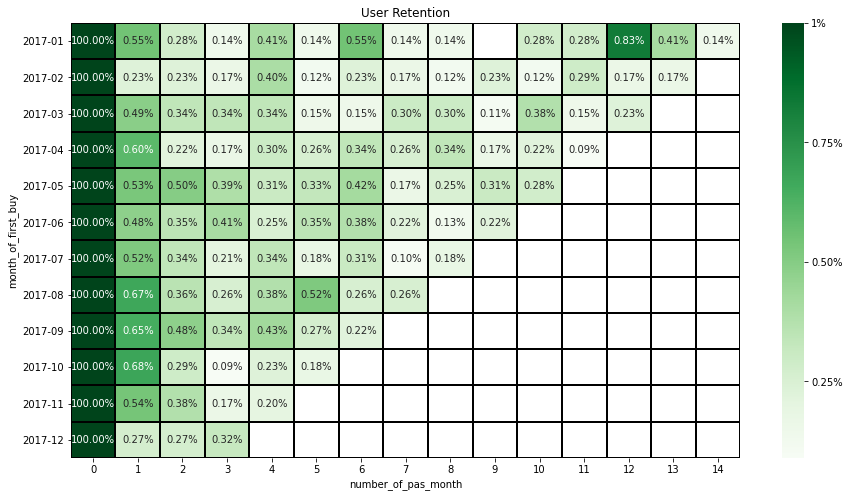

In [84]:
plt.figure(figsize=(15, 8))
plt.title('User Retention')
ax = sns.heatmap(retention_1, annot=True, fmt='.2%',vmax=0.01, linewidths=1, linecolor='black', cmap = "Greens")
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .0025, .005, .0075, 0.01])
cbar.set_ticklabels(['0%', '0.25%', '0.50%', '0.75%', '1%'])

In [ ]:
# По тепловой карте находим ответ на поставленный вопрос в задаче.

# Когорта с наивысшим "retention rate" на третий месяц - уникальные пользователи, совершившие первую покупку в Мае 2017.

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

В кластеризации можешь выбрать следующие метрики:

R - время от последней покупки пользователя до текущей даты,

F - суммарное количество покупок у пользователя за всё время,

M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.



In [ ]:
Так как RFM - сегментация рассматривает пользователей, совершивших покупки, 
то воспользуемся фреймом "customers_and_orders_without_NAN_and_unav".
Так как в RFM необходим подсчет средств, то необходимо также учеть датафрейм "items".
В 3 задании мы уже совмещали два данных фрейма, поэтому воспользуемся, полученным на том шаге "for_items_per_days"
для решения поставленной задачи (для удобства переименуем его и оставим только необходимые колонки).

In [87]:
for_items_per_days = users_and_orders.merge(items, how = 'inner', on = 'order_id')

In [88]:
for_RFM = for_items_per_days[['order_id', 'order_approved_at', 'customer_unique_id', 'price']]

In [95]:
for_RFM.head(3)

,order_id,order_approved_at,customer_unique_id,price
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,861eff4711a542e4b93843c6dd7febb0,124.99
1,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,290c77bc529b7ac935b93aa66c333dc3,289.00
2,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,060e732b5b29e8181a18229c7b0b2b5e,139.94


In [96]:
for_RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            112650 non-null  object        
 1   order_approved_at   112635 non-null  datetime64[ns]
 2   customer_unique_id  112650 non-null  object        
 3   price               112650 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.3+ MB


In [90]:
# Посмотрим, какой временой интервал охватывает наш полученный фрейм. А также на дату последней покупки

In [91]:
for_RFM['order_approved_at'].max() - for_RFM['order_approved_at'].min()

Timedelta('718 days 05:23:28')

In [ ]:
# дата последней покупки

In [92]:
last_date = for_RFM['order_approved_at'].max()

In [93]:
last_date

Timestamp('2018-09-03 17:40:06')

In [ ]:
# Как видим, охватываемый диапазон составляет чуть больше 718 дней,
# а последняя покупка была совершена в сентябре 2018.
# Поэтому для проведения RFM анализа возьмем за точку отсчета дату - следующую за днем последней оплаты.

In [97]:
NOW = for_RFM['order_approved_at'].max() + timedelta(days=1)
NOW

NameError: name 'timedelta' is not defined

In [98]:
# Сгруппируем полученный фрейм по уникальным пользователям и произведем расчет показателей RFM

In [99]:
RFM = for_RFM.groupby('customer_unique_id', as_index=False)\
.agg({'order_approved_at': lambda x: (last_date - x.max()).days, 
      'order_id': 'count', 
      'price': 'sum'})\
.rename(columns={'order_approved_at'  : 'recency', 
                 'order_id'    : 'frequency', 
                 'price': 'monetary'})

In [100]:
RFM.head(3)

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1,18.9
2,0000f46a3911fa3c0805444483337064,541.0,1,69.0


In [ ]:
# Посмотрим на распределения полученных нами колонок и определимся с разбиенем для них.

In [101]:
RFM.recency.describe()

count    95407.000000
mean       242.642626
std        153.126888
min          0.000000
25%        118.000000
50%        223.000000
75%        352.000000
max        718.000000
Name: recency, dtype: float64

In [ ]:
# С учетом того, что весь временной диапазон составляет 718 дней,
# в целом для метрики "recensy" можно использовать разбиение по квартилям.


In [102]:
RFM.frequency.describe()

count    95420.00000
mean         1.18057
std          0.62145
min          1.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         24.00000
Name: frequency, dtype: float64

In [ ]:
# Для "frequency" по квартилям разбивать  нецелесообразно.

In [103]:
RFM.groupby('frequency').customer_unique_id.count()

frequency
1     83551
2      8996
3      1672
4       632
5       254
6       198
7        46
8        16
9        11
10       11
11       11
12        9
13        2
14        3
15        2
16        1
18        1
20        2
21        1
24        1
Name: customer_unique_id, dtype: int64

In [ ]:
# В соответствии с тем, что практически 88 % пользователей совершили только одну покупку,
# целесообразней в данном случае будет сделать разбиение "вручную".

# 1 - пользователи, совершившие 1 покупку;
# 2 - 2 покупки;
# 3 - 3 покупки;
# 4 - 4-6 покупок;
# 5 - 7 и более покупок.

In [104]:
RFM.monetary.describe()

count    95420.000000
mean       142.440198
std        217.656355
min          0.850000
25%         47.900000
50%         89.900000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64

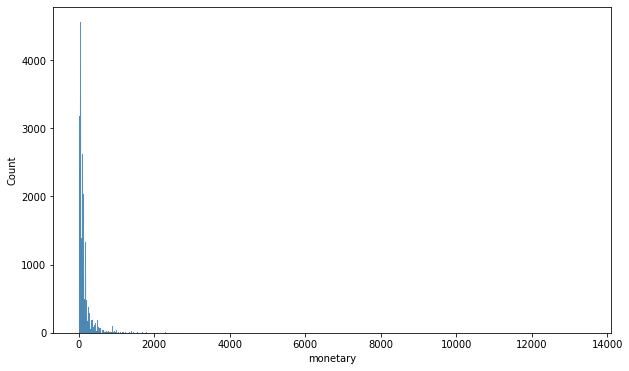

In [105]:
plt.figure(figsize=(10, 6))
sns.histplot(RFM.monetary)

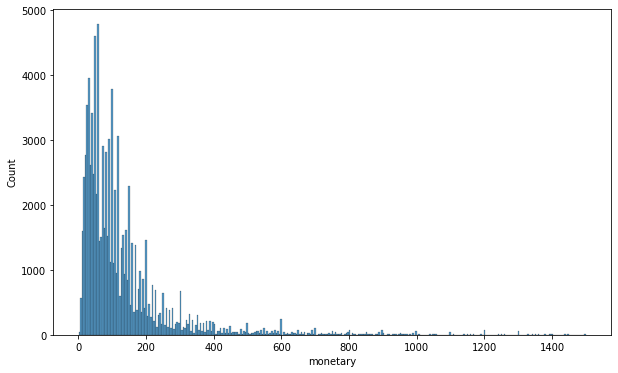

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(RFM[RFM.monetary < 1500], x = 'monetary')

In [ ]:
# В целом, и в описательной статистики датфрейма, и на графиках видно,
# что большинство пользователей потратили менее 200 у.е. Вполне уместно для "monetary" использовать квартильный подход.

In [ ]:
# Создадим словарь со значениями наших разбиений.

In [107]:
razbienie = RFM[['recency','monetary']].quantile([.2, .4, .6, .8])

In [108]:
razbienie['frequency'] = [1, 2, 3, 6]

In [109]:
quant = razbienie.to_dict()

In [110]:
quant

{'recency': {0.2: 97.0, 0.4: 181.0, 0.6: 272.0, 0.8: 388.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9},
 'frequency': {0.2: 1, 0.4: 2, 0.6: 3, 0.8: 6}}

In [111]:
# Создадим функции для определения ранга наших пользователей.

In [112]:
def R(x):
    if x <= quant['recency'][.2]:
        return 5
    elif x <= quant['recency'][.4]:
        return 4
    elif x <= quant['recency'][.6]:
        return 3
    elif x <= quant['recency'][.8]:
        return 2
    else:
        return 1

def FM(x, c):
    if x <= quant[c][.2]:
        return 1
    elif x <= quant[c][.4]:
        return 2
    elif x <= quant[c][.6]:
        return 3
    elif x <= quant[c][.8]:
        return 4
    else:
        return 5 

In [113]:
RFM['R'] = RFM['recency'].apply(lambda x: R(x))
RFM['F'] = RFM['frequency'].apply(lambda x: FM(x, 'frequency'))
RFM['M'] = RFM['monetary'].apply(lambda x: FM(x, 'monetary'))
RFM['RFM_score'] = RFM.R.map(str) + RFM.F.map(str) + RFM.M.map(str)

In [114]:
RFM.head(3)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,129.9,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1,18.9,4,1,1,411
2,0000f46a3911fa3c0805444483337064,541.0,1,69.0,1,1,2,112


Для лучшего восприятия можно разбить всех пользователей на основе их RFM - рейтинга на группы.

Основываясь на их RF значениях были выделены следующие группы:

    1) Лучшие пользователи - Покупали недавно, покупают часто и тратят больше всего;
    2) Постоянные клиенты - Покупают на постоянной основе;
    3) Потенциальные лояльные пользователи - Покупатели со средней частотой покупок;
    4) Недавние клиенты - Покупали совсем недавно, но не часто;
    5) Многообещающие - Недавние покупатели, но потратили не так уж много;
    6) Нуждающиеся во внимании - Выше среднего по новизне, частоте и денежным ценностям. Хотя, возможно, совершали покупки не совсем недавно;
    7) Малоактивные - С частотой ниже средней;
    8) В зоне риска - Приобретали часто, но давным-давно. Нужно вернуть их обратно!;
    9) Не можем их потерять - Совершали покупки часто, но долгое время не возвращались.
    10) Неактивные - Последняя покупка была совершена давно и с небольшим количеством заказов. Может быть потерян.

In [115]:
segt_map = {
    r'[1-2][1-2]': 'Неактивные',
    r'[1-2][3-4]': 'В зоне риска',
    r'[1-2]5': 'Не можем их потерять',
    r'3[1-2]': 'Малоактивные',
    r'33': 'Нуждающиеся во внимании',
    r'[3-4][4-5]': 'Постоянные клиенты',
    r'41': 'Многообещающие',
    r'51': 'Недавние клиенты',
    r'[4-5][2-3]': 'Потенциальные лояльные пользователи',
    r'5[4-5]': 'Лучшие пользователи'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116.0,1,129.90,4,1,4,414,Многообещающие
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1,18.90,4,1,1,411,Многообещающие
2,0000f46a3911fa3c0805444483337064,541.0,1,69.00,1,1,2,112,Неактивные
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,1,25.99,2,1,1,211,Неактивные
4,0004aac84e0df4da2b147fca70cf8255,292.0,1,180.00,2,1,5,215,Неактивные


In [ ]:
# После того, как мы полуличли RFM-оценки для наших пользователей,
# мы можем провести некоторую визуализацию данных, чтобы получить лучшее представление о них.
# Для начала посмотрим на распределения R, F и M.

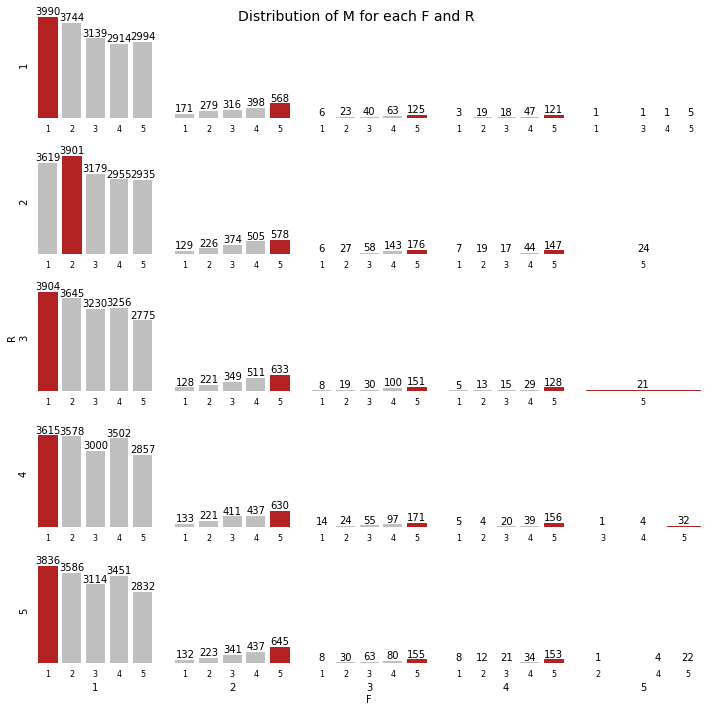

In [116]:
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = RFM[(RFM['R'] == r) & (RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# И напоследок посмотрим на распределения для наших сегментов.

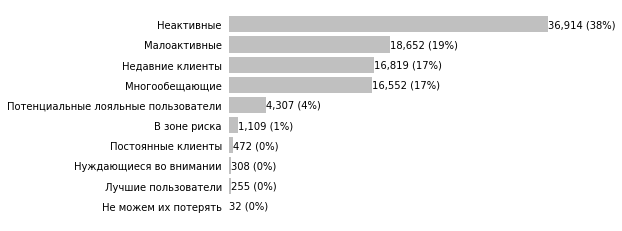

In [118]:
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()